Clustering reference spectra for each unknown.

In [1]:
import glob
import itertools
import logging
from operator import attrgetter
import os
import pprint
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.misc

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import sklearn.utils

import mrfitty

from mrfitty.base import AdaptiveEnergyRangeBuilder
from mrfitty.base import ReferenceSpectrum
from mrfitty.base import InterpolatedSpectrumSet

logging.basicConfig(level=logging.WARN)

In [2]:
sample_data_dir_path = os.path.join(
    os.path.dirname(mrfitty.__path__[0]),
    'example',
    'arsenic'
)  

print('sample data is installed at "{}"'.format(sample_data_dir_path))
os.path.exists(sample_data_dir_path)

sample data is installed at "/home/jklynch/host/project/mr-fitty/src/example/arsenic"


True

Read sample and reference data files.

In [3]:
sample_data_reference_glob = os.path.join(sample_data_dir_path, 'reference/*als_cal*.e')
print('sample data reference glob: {}'.format(sample_data_reference_glob))
sample_data_unknown_glob = os.path.join(sample_data_dir_path, 'unknown/*.e')
print('sample data unknown glob: {}'.format(sample_data_unknown_glob))

sample data reference glob: /home/jklynch/host/project/mr-fitty/src/example/arsenic/reference/*als_cal*.e
sample data unknown glob: /home/jklynch/host/project/mr-fitty/src/example/arsenic/unknown/*.e


In [4]:
sample_reference_data_set, _ = ReferenceSpectrum.read_all([sample_data_reference_glob])
print('sample data reference file count: {}'.format(len(sample_reference_data_set)))
sample_data_unknown_set, _ = ReferenceSpectrum.read_all([sample_data_unknown_glob])
print('sample data unknown file count: {}'.format(len(sample_data_unknown_set)))

sample data reference file count: 20
sample data unknown file count: 16


In [5]:
# this is a helper function for cluster_with_sig_cut
def permute_row_elements(df):
    for i in range(df.shape[0]):
        df.values[i, :] = sklearn.utils.shuffle(df.values[i, :])
    return df
# demonstrate permuting row elements
x_df = pd.DataFrame(data=np.array(range(9)).reshape((3,3)))
print('before permuting row elements:')
print(x_df.head())
permute_row_elements(x_df)
print('after permuting row elements:')
print(x_df)

before permuting row elements:
   0  1  2
0  0  1  2
1  3  4  5
2  6  7  8
after permuting row elements:
   0  1  2
0  0  1  2
1  3  5  4
2  6  7  8


In [6]:
def cluster_with_sig_cut(variable_by_sample_df, pdist_metric, linkage_method):
    distance_for_sample_pairs = pdist(
        X=np.transpose(variable_by_sample_df.values),
        metric=pdist_metric)
    
    #plt.figure()
    #plt.title(title)
    #plt.hist(distance_for_sample_pairs)
    #plt.xlabel('{} distance'.format(pdist_metric))
    #plt.ylabel('{} pairs'.format(variable_by_sample_df.shape))
    #plt.show()

    resample_count = 100
    expected_distance_list = []
    for i in range(resample_count):
        # permute the elements of each row of variable_by_sample_df
        p_variable_by_sample_df = permute_row_elements(variable_by_sample_df.copy())
        p_distance_for_sample_pairs = pdist(X=np.transpose(p_variable_by_sample_df.values), metric=pdist_metric)
        p_linkage_distance_variable_by_sample = hc.linkage(y=p_distance_for_sample_pairs, method=linkage_method)
        p_dendrogram = hc.dendrogram(Z=p_linkage_distance_variable_by_sample, no_plot=True)
        expected_distance_list.extend([d for (_, _, d, _) in p_dendrogram['dcoord']])

    p = 95.0
    alpha = 1.0 - p/100.0
    cutoff_distance = np.percentile(expected_distance_list, q=p)
    print('cutoff distance is {}'.format(cutoff_distance))

    #plt.figure()
    #plt.hist(expected_distance_list)
    #plt.title('dendrogram distance null distribution')
    #plt.show()

    linkage_distance_variable_by_sample = hc.linkage(y=distance_for_sample_pairs, method=linkage_method)

    return linkage_distance_variable_by_sample, cutoff_distance

In [7]:
def get_leaf_color(linkage_distance, dendrogram):
    """
    Return a list of leaf colors for the specified tree in left-to-right order as they
    appear in the dendrogram plot.

    Make a depth-first traversal of a ClusterNode tree.
    Assign leaf color from dendrogram['color_list'], which is a list of branch colors
    in depth-first order.

    For example:
        dendrogram['color_list'] is ['g', 'r', 'r', 'b']
        tree looks like
                              node_0
                   node_1                node_2
              leaf_1    leaf_2      node_3    leaf_5
                               leaf_3    leaf_4
        node_1 is 'g' so
            leaf_1 is 'g'
            leaf_2 is 'g'
        node_3 is 'r' so
            leaf_3 is 'r'
            leaf_4 is 'r'
        node_2 is 'r' so
            leaf_5 is 'r'

        A depth-first traversal will visit the nodes in this order:
            leaf_1
            leaf_2
            node_1
            leaf_3
            leaf_4
            node_3
            leaf_5
            node_2
            node_5
        Insert branch_node_id -> branch_node_color in the branch color dictionary
        (note: ClusterNode is not hashable :<)
            node_1.id: 'g'
            node_3.id: 'r'
            node_2.id: 'r'
            node_0.id: 'b'
        Use the branch color dictionary to assign leaf node colors.
    """
    tree = hc.to_tree(linkage_distance)
    branch_color_list = dendrogram['color_list']
    
    def depth_first_traversal(node_, branch_nodes_, leaf_nodes_):
        if node_.is_leaf():
            leaf_nodes_.append(node_)
        else:
            depth_first_traversal(node_.get_left(), branch_nodes_, leaf_nodes_)
            depth_first_traversal(node_.get_right(), branch_nodes_, leaf_nodes_)
            branch_nodes_.append(node_)

    branch_nodes_dfo = []
    leaf_nodes_dfo = []
    depth_first_traversal(tree, branch_nodes_dfo, leaf_nodes_dfo)
    #print(
    #    'branch_nodes:\n\t{}'.format(
    #        '\n\t'.join(
    #            [str(b.get_id()) for b in branch_nodes_dfo]
    #        )
    #    )
    #)
    #print(
    #    'leaf_nodes:\n\t{}'.format(
    #        '\n\t'.join(
    #            [str(l.get_id()) for l in leaf_nodes_dfo]
    #        )
    #    )
    #)

    branch_node_to_color = {
        b.get_id(): (b, c) for b, c in zip(branch_nodes_dfo, branch_color_list)
    }
    #print(
    #    'branch_node_to_color:\n{}'.format(
    #        '\n'.join(
    #            ['{}->{}'.format(b.get_id(), c) for b_id, (b, c) in branch_node_to_color.items()]
    #        )
    #    )
    #)

    leaf_node_to_color = {}
    for branch_node_id, (branch_node, branch_color) in branch_node_to_color.items():
        right_node = branch_node.get_right()
        if right_node.is_leaf():
            leaf_node_to_color[right_node.get_id()] = (right_node, branch_color)
        else:
            pass
        left_node = branch_node.get_left()
        if left_node.is_leaf():
            leaf_node_to_color[left_node.get_id()] = (left_node, branch_color)
        else:
            pass

    #print(
    #    'leaf_node_to_color:\n{}'.format(
    #        '\n'.join(
    #            ['{}->{}'.format(l.get_id(), c) for l_id, (l, c) in leaf_node_to_color.items()]
    #        )
    #    )
    #)

    leaf_node_color_dfo = [leaf_node_to_color[l.get_id()] for l in leaf_nodes_dfo]
    
    return leaf_node_color_dfo

In [8]:
def plot_clusters(linkage_distance_variable_by_sample, variable_by_sample_df, cutoff_distance, title, linkage_method, pdist_metric):
    f, ax = plt.subplots(figsize=(3.7, 7))
    dendrogram = hc.dendrogram(
        ax=ax,
        Z=linkage_distance_variable_by_sample,
        orientation='left',
        labels=variable_by_sample_df.columns)

    #print('dendrogram.color_list:\n{}'.format(dendrogram['color_list']))
    #print('dendrogram.ivl:\n{}'.format(dendrogram['ivl']))
    #print('dendrogram.leaves:\n{}'.format(dendrogram['leaves']))
    #print('to_tree(Z):\n{}'.format(tree))
    
    # dendrogram['color_list'] is in depth-first order
    # leaf_node_color is also in depth-first order
    leaf_node_color = get_leaf_color(linkage_distance_variable_by_sample, dendrogram)
    
    #leaf_colors = plt.cm.get_cmap("Accent", 2)
    #for i, leaf_label in enumerate(plt.gca().get_ymajorticklabels()):
    #    # leaf_label.get_text() looks like 'arsenopyrite_ref_als_cal.e'
    #    #print(leaf_label.get_text())
    #    leaf_label.set_color(leaf_colors(i % 2))
    
    for leaf_label, (leaf_node, leaf_color) in zip(ax.get_ymajorticklabels(), leaf_node_color):
        leaf_label.set_color(leaf_color)
    
    icoords = tuple([i for i in itertools.chain(dendrogram['icoord'])])
    ax.vlines(cutoff_distance, ymin=np.min(icoords), ymax=np.max(icoords))
    ax.set_title('{}\n{} linkage'.format(title, linkage_method))
    ax.set_xlabel('{} distance'.format(pdist_metric))
    f.savefig(title + '.pdf', format='pdf')
    plt.show()

cutoff distance is 0.2771633274306631


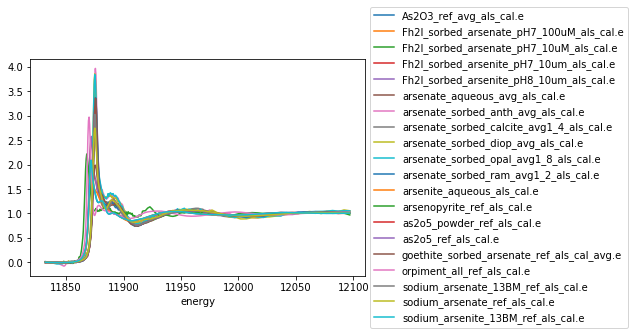

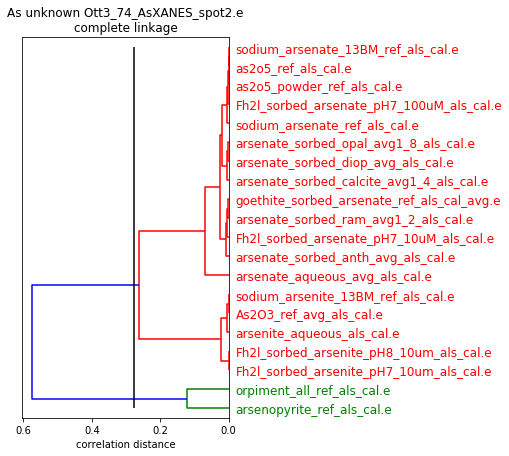

cutoff distance is 0.36641652727642776


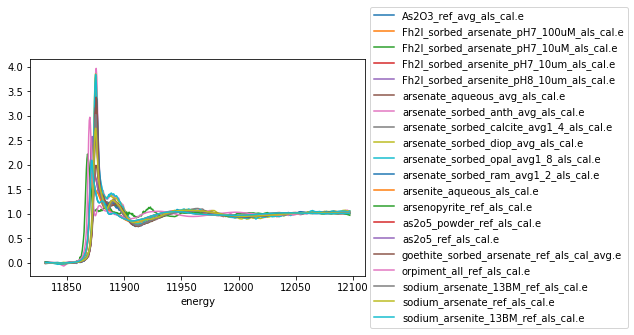

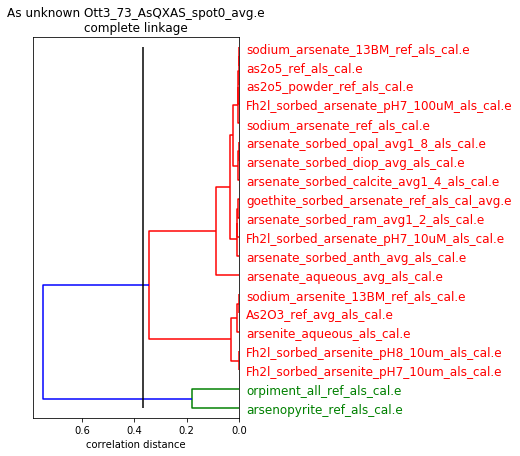

cutoff distance is 0.2725456028770038


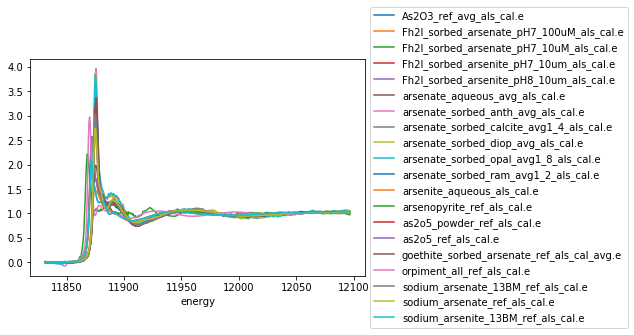

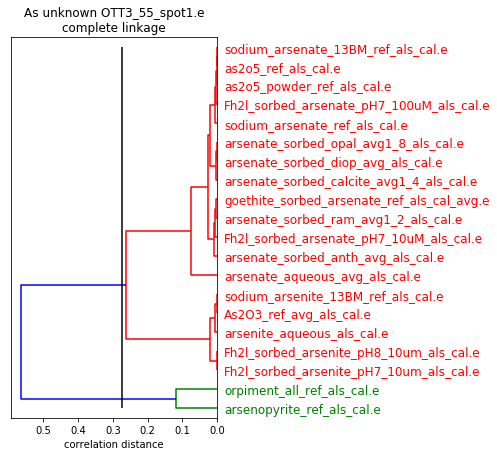

cutoff distance is 0.26700408769640155


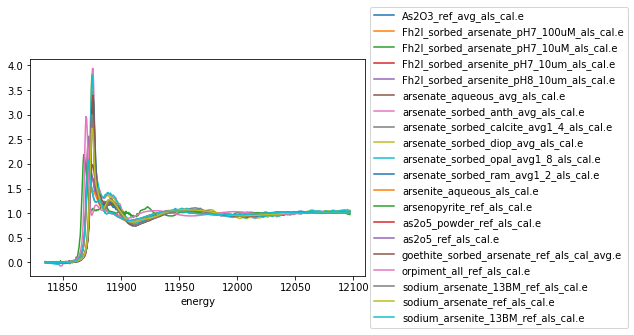

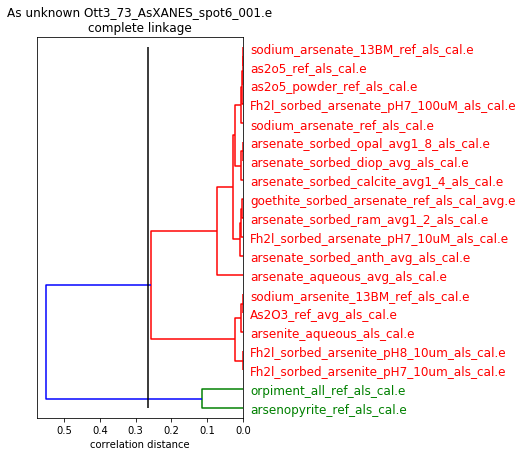

cutoff distance is 0.27962393381611544


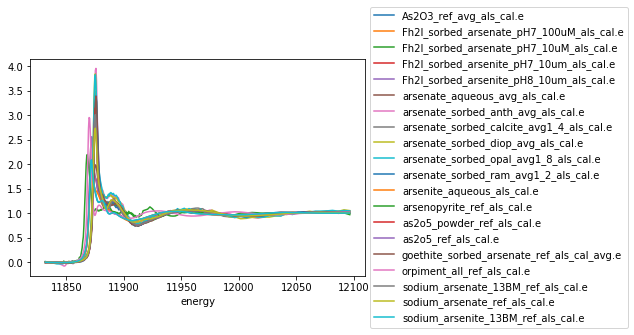

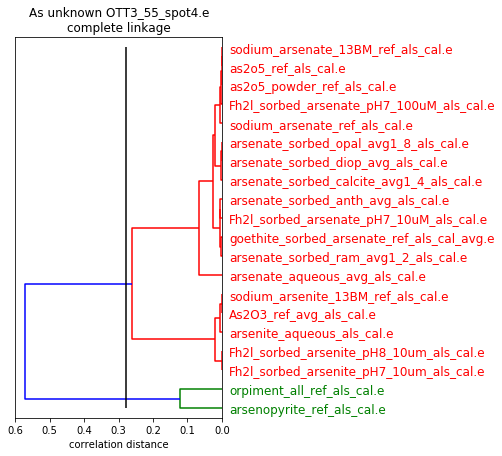

cutoff distance is 0.26893664532030725


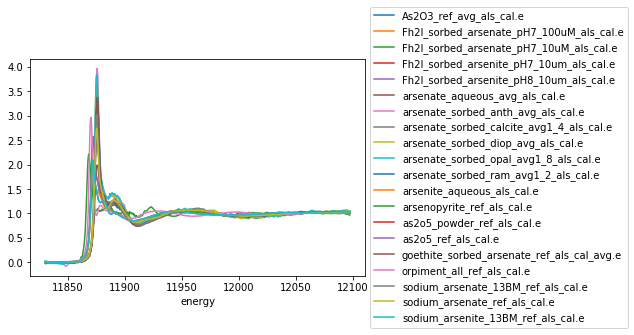

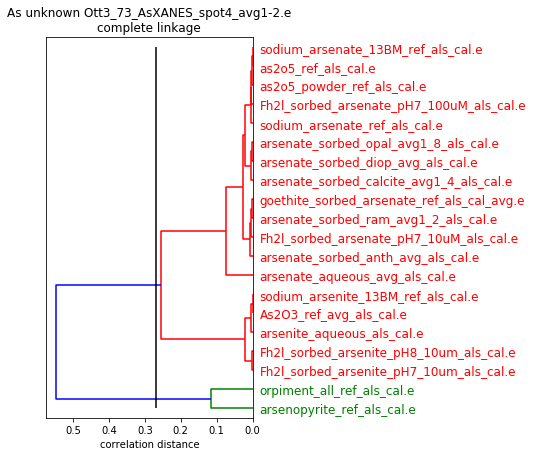

cutoff distance is 0.27850280536853333


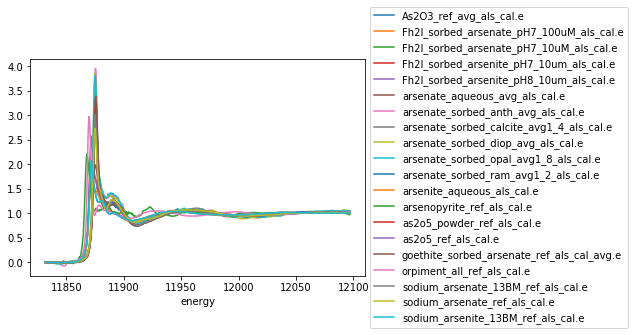

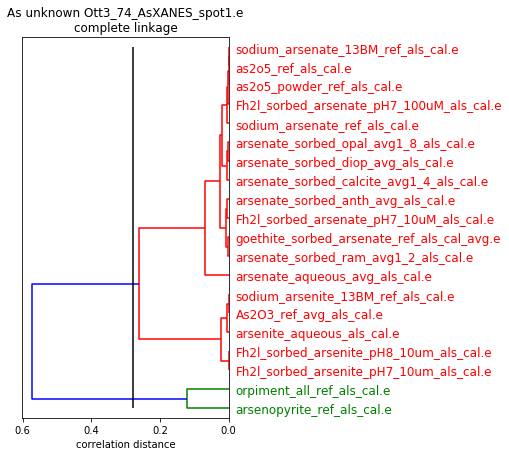

cutoff distance is 0.260369033464798


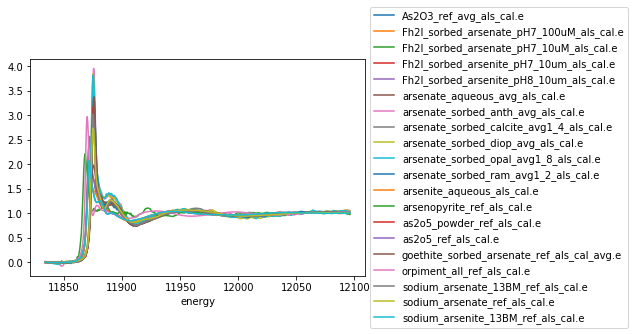

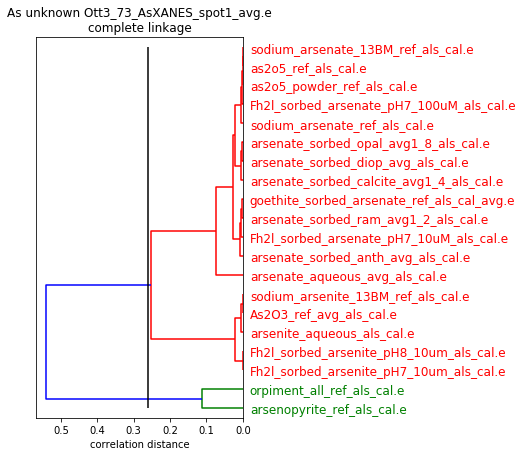

cutoff distance is 0.26601869846758575


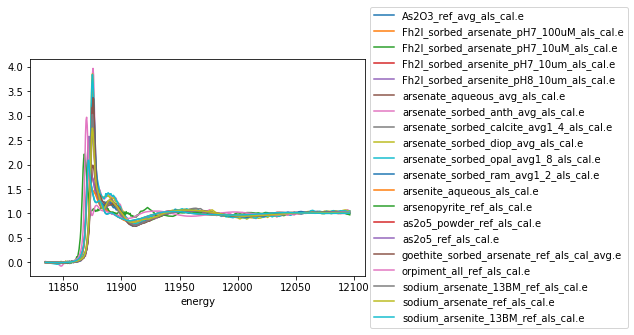

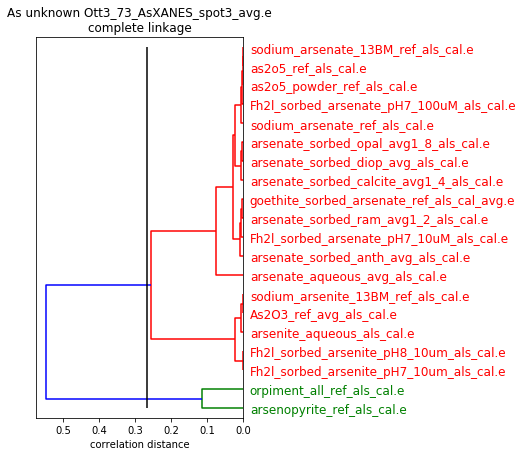

cutoff distance is 0.2774583620014813


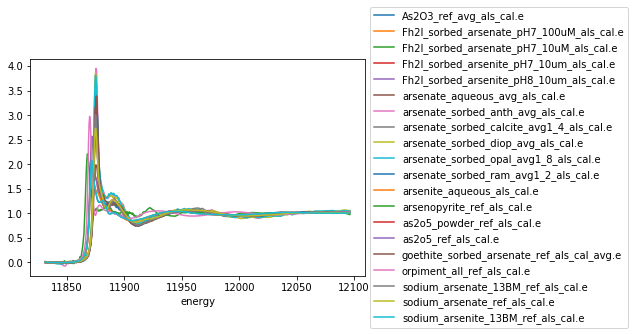

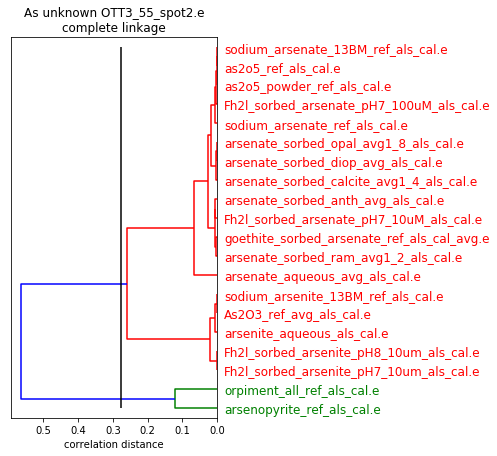

cutoff distance is 0.2702715277176582


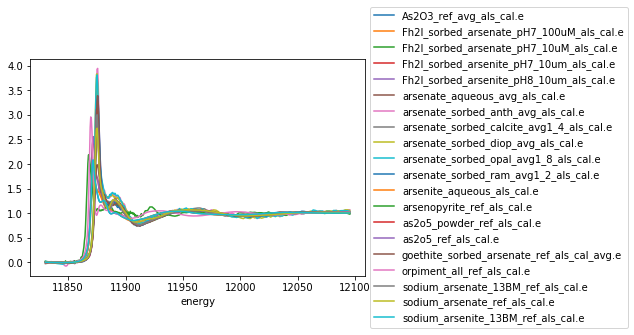

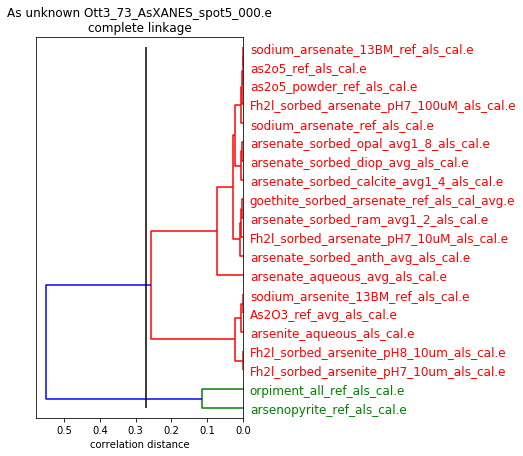

cutoff distance is 0.27630439794976924


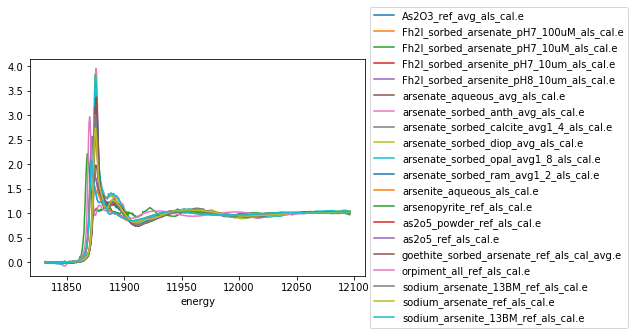

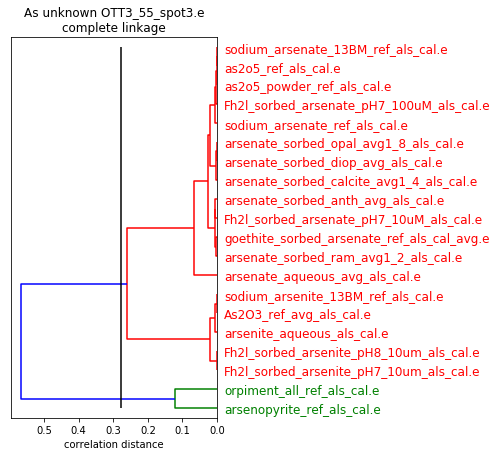

cutoff distance is 0.26580383424195697


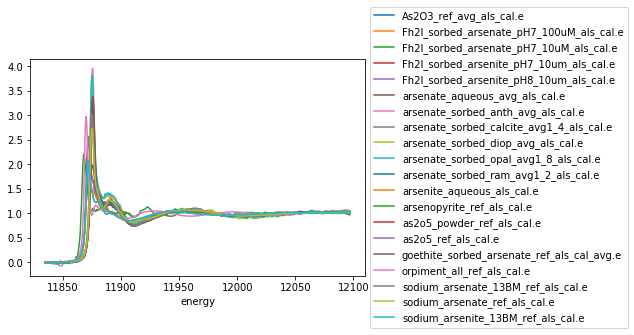

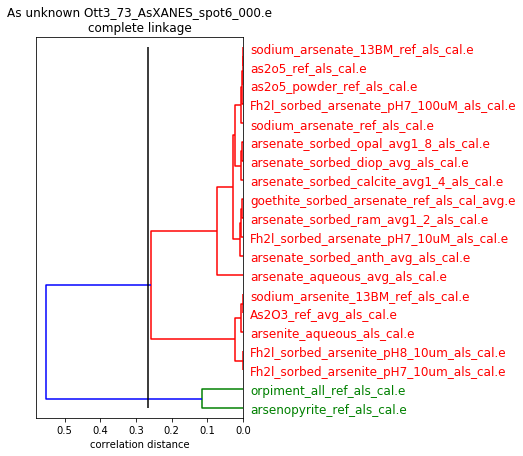

cutoff distance is 0.27760775252359726


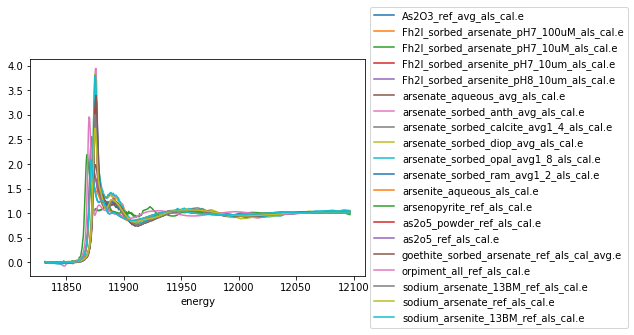

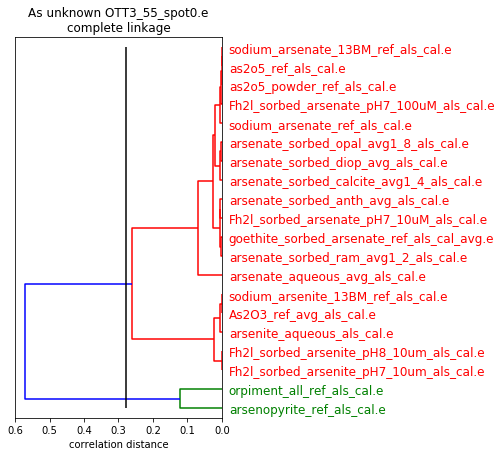

cutoff distance is 0.2784118485546152


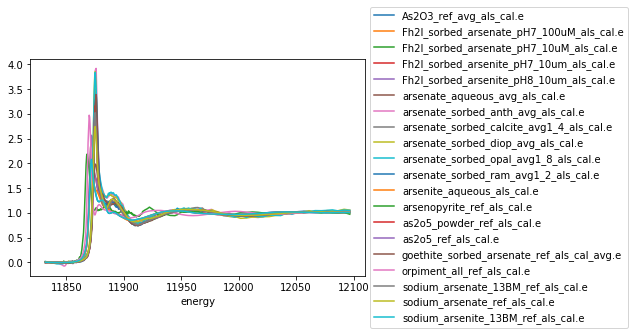

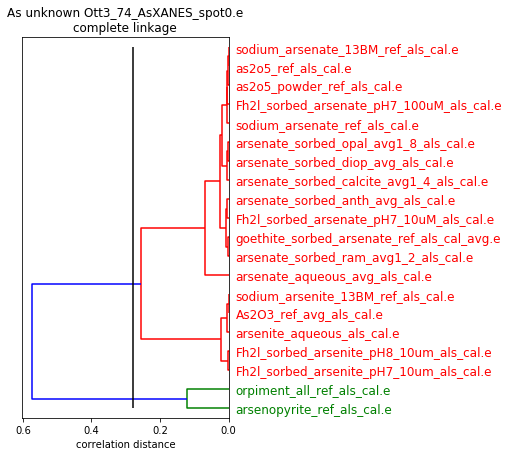

cutoff distance is 0.265684649980515


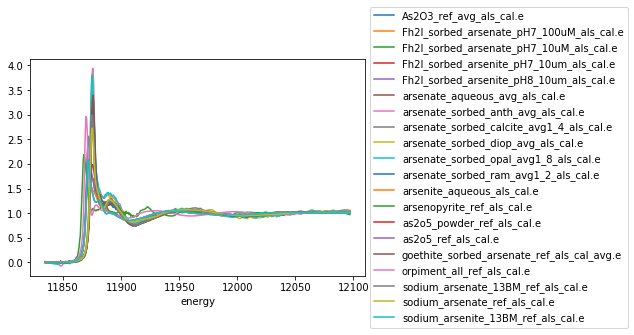

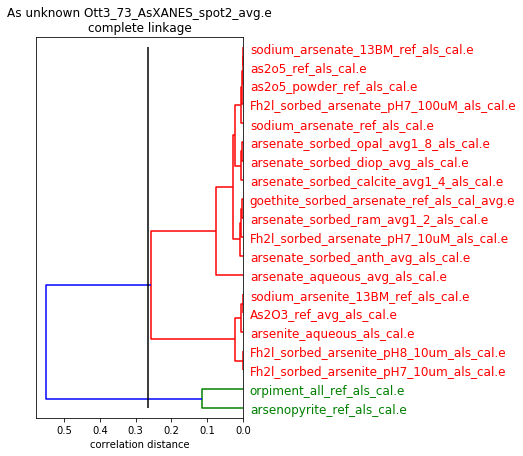

In [9]:
for sample_data_unknown in sample_data_unknown_set:
    interpolation_energy_range, _ = AdaptiveEnergyRangeBuilder().build_range(
        unknown_spectrum=sample_data_unknown,
        reference_spectrum_seq=sample_reference_data_set)
    interpolated_reference_set_df = InterpolatedSpectrumSet.get_interpolated_spectrum_set_df(
        energy_range=interpolation_energy_range,
        spectrum_set=set(sample_reference_data_set))
    interpolated_reference_set_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #print(interpolated_reference_set_df.head())

    clustering_parameters = {
        'linkage_method': 'complete',
        'pdist_metric': 'correlation'
    }
    
    linkage_distance, cutoff_distance = cluster_with_sig_cut(
        interpolated_reference_set_df,
        **clustering_parameters)

    plot_clusters(
        linkage_distance,
        interpolated_reference_set_df,
        cutoff_distance,
        title='As unknown {}'.format(sample_data_unknown.file_name),
        **clustering_parameters)